### Knapsack Problem using Quantum Approximate Optimization Algorithm with Qiskit

This tutorial will walk you through solving the Knapsack problem, a classic optimization challenge, using a quantum algorithm called the Quantum Approximate Optimisation Algorithm (QAOA). We will use Qiskit to define the problem, convert it into a format suitable for a quantum computer, and then use VQE to find an approximate solution.

First, let's ensure Qiskit is installed and check the version.

In [1]:
import qiskit
print(qiskit.__version__)

1.3.1


### The Knapsack Problem

The Knapsack problem involves selecting a set of items, each with a specific weight and value, to maximize the total value without exceeding a given maximum weight capacity. It's a binary optimization problem: for each item, you either include it in the knapsack or you don't.

### Setting Up the Environment

Before we define the problem, we need to import the necessary libraries. These include:

- **Basic libraries:** numpy for numerical operations and matplotlib for plotting.

- **Qiskit Optimization:** Tools to define the Knapsack problem (Knapsack), convert it into a quadratic program, and map it to a quantum problem (QuadraticProgramToQubo).

- **Qiskit Algorithms:** The core QAOA components, including the Estimator primitive for calculating expectation values and the EfficientSU2 ansatz.

- **SciPy:** A classical optimizer that QAOA will use to minimize the cost function.

- **Qiskit Aer:** To simulate a quantum backend for our experiment.

In [2]:
# basic imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# quantum imports
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.applications import Maxcut, Knapsack
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import QAOAAnsatz
# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

### **Generate a Random Instance**

To make things interesting, let's create a random instance of the Knapsack problem. We'll define the number of items and generate random weights and values for each. The knapsack's capacity is set to 60% of the total weight of all items.

We then create a `Knapsack` object and convert it to a `QuadraticProgram`, which is a standard format for optimization problems.

In [3]:
# Set the random seed for reproducibility
np.random.seed(135)

# Parameters for the knapsack problem
num_items = 4
max_weight = 8

# Generate random weights and values for the items

weights = np.random.randint(1, 10, size=num_items)
values = np.random.randint(10, 50, size=num_items)

# Capacity of the knapsack
capacity = int(0.6 * np.sum(weights))

print(f"Weights: {weights}")
print(f"Values: {values}")
print(f"Capacity: {capacity}")

# Create the Knapsack problem
knapsack = Knapsack(values.tolist(), weights.tolist(), capacity)

# Convert the problem to a QuadraticProgram
problem = knapsack.to_quadratic_program()
print(problem.prettyprint())



Weights: [6 9 7 8]
Values: [29 41 41 39]
Capacity: 18
Problem name: Knapsack

Maximize
  29*x_0 + 41*x_1 + 41*x_2 + 39*x_3

Subject to
  Linear constraints (1)
    6*x_0 + 9*x_1 + 7*x_2 + 8*x_3 <= 18  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [54]:
num_binary_vars_classical = problem.get_num_binary_vars()
print(f"Number of binary variables: {num_binary_vars_classical}")

Number of binary variables: 4


### **Finding the Exact Solution Classically**

Before turning to a quantum approach, let's find the exact solution using a classical optimizer. This will serve as our benchmark to see how well the VQE performs. We use the `CplexOptimizer` from Qiskit Optimization for this purpose. The solution `x` is a binary vector where `1` means an item is selected and `0` means it's left out.

In [5]:
# Solve the problem using CplexOptimizer
optimizer = CplexOptimizer()
result = optimizer.solve(problem)

result_classical = result
print(f"Optimal value: {result_classical.fval}, Solution vector: {result_classical.x}")


Optimal value: 82.0, Solution vector: [0. 1. 1. 0.]


### **From Quadratic Program to QUBO**

Quantum computers solve problems formulated as Hamiltonians. A common step is to first convert the problem into a **Quadratic Unconstrained Binary Optimization (QUBO)** problem. This format represents the problem as a single quadratic equation to be minimized, without any constraints.

The conversion automatically creates "slack" variables to transform the inequality constraint (total weight <= capacity) into an equality, which is then incorporated into the objective function with a penalty.

In [6]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Minimize
 obj: - 32645 x_0 - 48965 x_1 - 38093 x_2 - 43527 x_3 - 5436 c0@int_slack@0
      - 10872 c0@int_slack@1 - 21744 c0@int_slack@2 - 43488 c0@int_slack@3
      - 16308 c0@int_slack@4 + [ 10872 x_0^2 + 32616 x_0*x_1 + 25368 x_0*x_2
      + 28992 x_0*x_3 + 3624 x_0*c0@int_slack@0 + 7248 x_0*c0@int_slack@1
      + 14496 x_0*c0@int_slack@2 + 28992 x_0*c0@int_slack@3
      + 10872 x_0*c0@int_slack@4 + 24462 x_1^2 + 38052 x_1*x_2 + 43488 x_1*x_3
      + 5436 x_1*c0@int_slack@0 + 10872 x_1*c0@int_slack@1
      + 21744 x_1*c0@int_slack@2 + 43488 x_1*c0@int_slack@3
      + 16308 x_1*c0@int_slack@4 + 14798 x_2^2 + 33824 x_2*x_3
      + 4228 x_2*c0@int_slack@0 + 8456 x_2*c0@int_slack@1
      + 16912 x_2*c0@int_slack@2 + 33824 x_2*c0@int_slack@3
      + 12684 x_2*c0@int_slack@4 + 19328 x_3^2 + 4832 x_3*c0@int_slack@0
      + 9664 x_3*c0@int_slack@1 + 19328 x_3*c0@int_slack@2
      + 38656 x_3*c0@int_slac

As you can see, the QUBO has more variables than the original `num_items` because of the slack variables introduced to handle the weight constraint. Let's check the new number of variables.

In [7]:
num_vars = qubo.get_num_vars()
print(f"Number of variables in QUBO: {num_vars}")
print(f"Number of variables in classical formulation: {num_binary_vars_classical}")
increase = num_vars - num_binary_vars_classical
percent_increase = (increase / num_binary_vars_classical) * 100
print(f"Number of variables increased by {increase} ({percent_increase:.1f}%) when converting to QUBO (due to slack variables for constraints).")

Number of variables in QUBO: 9
Number of variables in classical formulation: 4
Number of variables increased by 5 (125.0%) when converting to QUBO (due to slack variables for constraints).


### **Mapping the QUBO to an Ising Hamiltonian**

The VQE algorithm works by finding the minimum energy (eigenvalue) of a Hamiltonian. We now convert our QUBO problem into an **Ising Hamiltonian**. This Hamiltonian is an operator that can be measured on a quantum computer. Each binary variable in the QUBO is mapped to a qubit.

The conversion gives us two components:

- `qubitOp`: The Ising Hamiltonian, represented as a sum of Pauli operators (Z, ZZ).

- `offset`: A constant energy shift that we'll add back to our final result.

In [8]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 17592.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-5421.5+0.j, -8133.5+0.j, -6321.5+0.j, -7228.5+0.j,  -906. +0.j,
 -1812. +0.j, -3624. +0.j, -7248. +0.j, -2718. +0.j,  4077. +0.j,
  3171. +0.j,  3624. +0.j,   453. +0.j,   906. +0.j,  1812. +0.j,
  3624. +0.j,  1359. +0.j,  4756.5+0.j,  5436. +0.j,   679.5+0.j,
  1359. +0.j,  2718. +0.j,  5436. +0.j,  2038.5+0.j,  4228. +0.j,
   528.5+0.j,

### **The Quantum Approximate Optimization Algorithm (QAOA)**

QAOA is another hybrid quantum-classical algorithm designed for optimization problems. It uses a special type of ansatz circuit that alternates between two operators: a **cost operator** (derived from our problem Hamiltonian) and a **mixer operator**.

The goal is to find the optimal parameters (angles) for these operators that prepare a quantum state with the lowest possible energy.



#### **The QAOA Ansatz**

The `QAOAAnsatz` circuit is constructed directly from our problem's cost operator (`qubitOp`). The `reps` parameter defines how many times the cost and mixer layers are repeated, which affects the circuit's complexity and potential accuracy.

Let's visualize the structure of our QAOA ansatz circuit with `reps=1`.

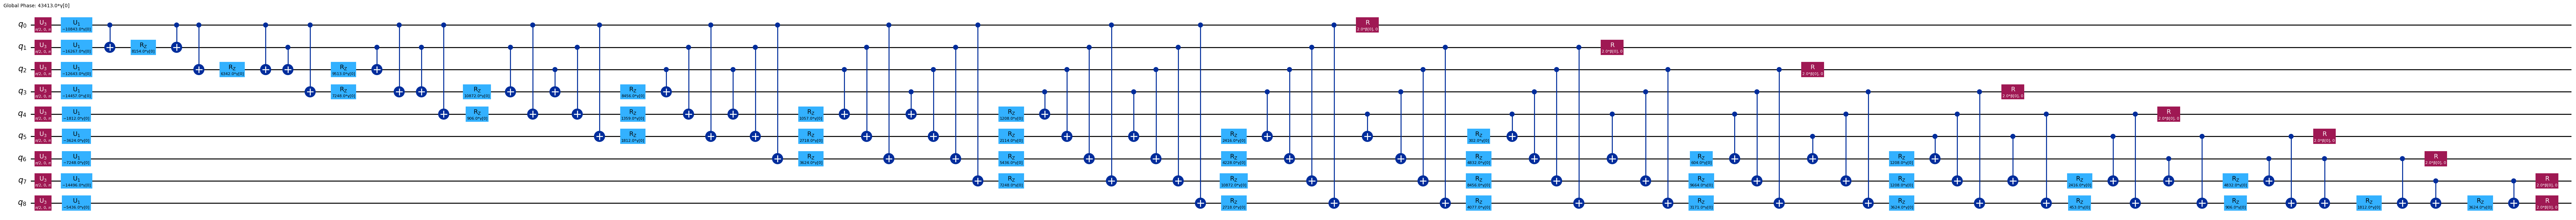

In [9]:
reps =1
circuit = QAOAAnsatz(cost_operator=qubitOp, reps=reps)
circuit = circuit.decompose(reps=3)
circuit.draw('mpl',fold=-1)

#### Executing the QAOA Algorithm

To run QAOA, we need to set up the classical optimization loop.

- **Initial Parameters:** We choose an initial set of parameters (beta and gamma angles) for the ansatz. A common starting point is `pi` for gamma and `pi/2` for beta, repeated for each rep.

- **Cost Function:** We define a `cost_func_estimator` that takes the parameters, builds the QAOA circuit, and uses the `Estimator` to calculate the expectation value (energy) of the Hamiltonian. This energy is what the classical optimizer will minimize. We also store the objective function values at each step to plot the convergence.

- **Classical Optimizer:** We use the `COBYLA` optimizer from SciPy to find the optimal beta and gamma angles that minimize the energy.

Here are our initial parameters:

In [10]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta]*reps
print(init_params)

[3.141592653589793, 1.5707963267948966]


This is the cost function that the optimizer will call:

In [11]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

Now, we execute the optimization loop.

In [47]:
objective_func_vals = [] # Store the objective function values

result = minimize(
    cost_func_estimator,
    init_params,
    args= (circuit, qubitOp, estimator),
    method="cobyla", # you can also use 'SLSQP' or 'L-BFGS-B'
    options={'maxiter': 800, 'disp': True},
    tol=1e-8
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1860.123046875
       x: [ 3.183e+00  2.549e+00]
    nfev: 55
   maxcv: 0.0


The optimizer has found the optimal parameters (according to QAOA) . Let's plot the objective function value at each iteration to see how the algorithm converged to the solution.

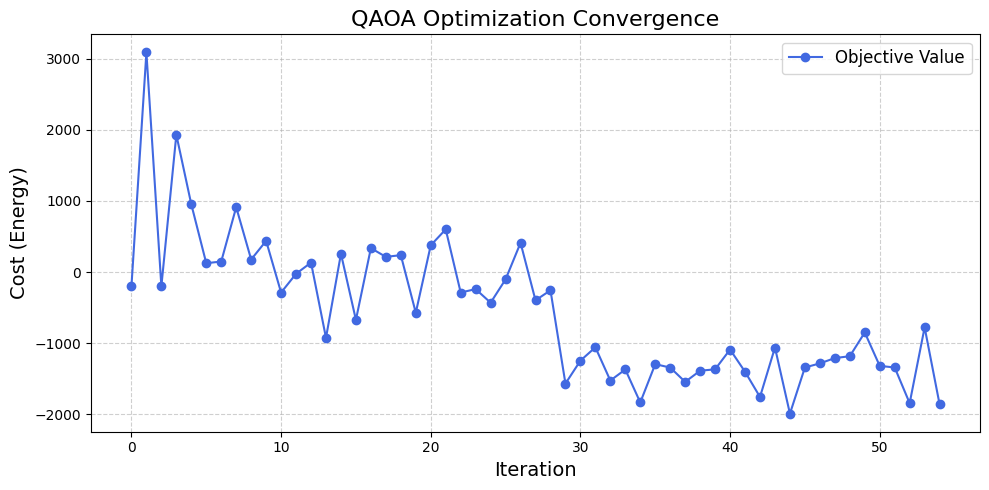

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(objective_func_vals, marker='o', linestyle='-', color='royalblue', label='Objective Value')
plt.title("QAOA Optimization Convergence", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Cost (Energy)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



### **Post-Processing: Sampling the Solution**

With the optimal parameters found, we now create the final QAOA circuit. We then add measurements and use the `Sampler` primitive to execute the circuit many times (shots) and obtain a probability distribution of the possible solution bitstrings.

The bitstring with the highest probability is our candidate for the optimal solution.

In [49]:
# Assign the optimal parameters to the ansatz
optimal_circuit = circuit.assign_parameters(result.x)
optimal_circuit.measure_all()

# Run the sampler job
pub = (optimal_circuit,)
job = sampler.run([pub], shots=int(1e4))

# Get the counts
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()

# Normalize the counts to get a probability distribution
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

Let's find the most likely bitstring from the final distribution.

In [50]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_vars)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 0, 0, 1, 1, 1]


In [51]:
result = converter.interpret(most_likely_bitstring)
cost = problem.objective.evaluate(result)
feasible =problem.get_feasibility_info(result)[0]


print("Result knapsack:", result)
print("Result value:", cost)
print("Feasible:", feasible)

Result knapsack: [0. 1. 1. 0.]
Result value: 82.0
Feasible: True


In [52]:
print("="*40)
print("🔎 Best Known Classical Solution")
print("="*40)
print(f"  • Total Value:        {result_classical.fval}")
print(f"  • Solution Vector:    {result_classical.x}")
print()

print("="*40)
print("⚛️  VQE (Quantum) Solution")
print("="*40)
print(f"  • Total Value:        {cost}")
print(f"  • Solution Vector:    {result}")
print(f"  • Feasible:           {feasible}")

if feasible:
    optimality_gap = 100 * (result_classical.fval - cost) / result_classical.fval
    print(f"  • Optimality Gap:     {optimality_gap:.2f}%")
else:
    print("  • Note: Quantum solution is not feasible.")

print("\n" + "-"*40)
if feasible:
    if abs(cost - result_classical.fval) < 1e-6:
        print("✅ Quantum solution matches the classical optimum!")
    else:
        print("ℹ️  Quantum solution is suboptimal compared to classical.")
else:
    print("❌ Quantum solution is not feasible.")
print("-"*40)

🔎 Best Known Classical Solution
  • Total Value:        82.0
  • Solution Vector:    [0. 1. 1. 0.]

⚛️  VQE (Quantum) Solution
  • Total Value:        82.0
  • Solution Vector:    [0. 1. 1. 0.]
  • Feasible:           True
  • Optimality Gap:     0.00%

----------------------------------------
✅ Quantum solution matches the classical optimum!
----------------------------------------


Since QAOA is a heuristic algorithm, it's a good practice to examine the top few most likely outcomes.

In [53]:
# Find the indices of the top 4 values
top_4_indices = np.argsort(np.abs(values))[::-1][:4]
top_4_results = []

# Table header
print("\nTop 4 Most Probable Solutions from VQE Measurement:\n")
header = (
    f"{'Rank':<5} | {'Bitstring':<{num_vars+2}} | {'Probability':<11} | "
    f"{'Knapsack Solution':<18} | {'Value':<7} | {'Feasible':<8} | {'Optimality Gap (%)':<18}"
)
print(header)
print("-" * len(header))

for rank, idx in enumerate(top_4_indices, 1):
    bitstring = to_bitstring(keys[idx], num_vars)
    bitstring.reverse()
    top_4_results.append(bitstring)
    interpreted = converter.interpret(bitstring)
    value = problem.objective.evaluate(interpreted)
    feasible = problem.get_feasibility_info(interpreted)[0]
    if feasible and result_classical.fval != 0:
        optimality_gap = 100 * (result_classical.fval - value) / result_classical.fval
        gap_str = f"{optimality_gap:>7.2f}"
    else:
        gap_str = "     N/A"
    print(
        f"{rank:<5} | {str(bitstring):<{num_vars+2}} | {values[idx]:<11.6f} | "
        f"{str(interpreted):<18} | {value:<7} | {str(feasible):<8} | {gap_str:<18}"
    )



Top 4 Most Probable Solutions from VQE Measurement:

Rank  | Bitstring   | Probability | Knapsack Solution  | Value   | Feasible | Optimality Gap (%)
------------------------------------------------------------------------------------------------
1     | [0, 1, 1, 0, 0, 0, 1, 1, 1] | 0.004200    | [0. 1. 1. 0.]      | 82.0    | True     |    0.00           
2     | [1, 1, 1, 0, 1, 0, 1, 0, 0] | 0.004100    | [1. 1. 1. 0.]      | 111.0   | False    |      N/A          
3     | [1, 0, 1, 1, 0, 1, 0, 0, 0] | 0.003900    | [1. 0. 1. 1.]      | 109.0   | False    |      N/A          
4     | [1, 1, 1, 1, 1, 0, 0, 1, 0] | 0.003800    | [1. 1. 1. 1.]      | 150.0   | False    |      N/A          
